<a href="https://colab.research.google.com/github/carlosdcorona/PySpark/blob/main/CurveFittingSharingBikeDaily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classwork 08: Curve Fitting with pySpark

### Bernardo Samuel Salazar de Hoyos A00825722
### Carlos Daniel Corona Cortez A01656002
### Sebastian Andres Saldaña Cárdenas A01570274
### Sergio Noé Torres Rodríguez A00825706
### Raúl V. Ramírez Velarde
### October 11, 2022

## Import pySpark modules

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop2.7.tgz
!tar xf spark-3.1.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
#All imports
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Import modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

## Mount Google Drive

In [ ]:
#Mount Google drive, read local file. The file was previously uploaded to Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Functions for modelling the problem.

In [ ]:
def vector_assembling(data,cols,colsname,targetcol):
    assembler = VectorAssembler(inputCols = cols, outputCol = colsname)
    output = assembler.transform(data)
    return output.select(colsname, targetcol)

In [ ]:
def regression(typeReg, datasplit, data, colsname, targetcol, summ, lstcols = []):
    train_data, test_data = data.randomSplit(datasplit)
    if typeReg == 'GBT':
        regressor = GBTRegressor(featuresCol = colsname, labelCol = targetcol)
    elif typeReg == 'RF':
        regressor = RandomForestRegressor(featuresCol = colsname, labelCol = targetcol)
    else:
        regressor = LinearRegression(featuresCol = colsname, labelCol = targetcol)

    regressor = regressor.fit(train_data)
    pred_reg = regressor.transform(test_data)
    pred_reg.select(colsname, targetcol, 'prediction').show(10)

    if summ:
        summary = regressor.summary
        for i,j in zip(lstcols,summary.pValues):
          print(i,np.format_float_positional(j, trim = '-'))

    evalreg = RegressionEvaluator(labelCol = targetcol, predictionCol = 'prediction', metricName = 'rmse')
    print(f"{typeReg} regression model\n")
    print("RMSE: %.3f" % evalreg.evaluate(pred_reg))
    r2 = evalreg.evaluate(pred_reg, {evalreg.metricName: "r2"})
    print("R2: %.2f" % r2)
    return r2

In [ ]:
def correlation_matrix_heatmap(df):
  plt.figure(figsize = (16,9))
  sns.heatmap(df.toPandas().corr(),annot = True,cmap="coolwarm", linecolor = 'k')
  plt.title("Correlation Matrix Heatmap of the DataFrame")

In [ ]:
def correlation_matrix_heatmap_filter(df,val):
  plt.figure(figsize = (16,9))
  corrdf = df.toPandas().corr()
  maskcorrdf = (corrdf >= val) | (corrdf <= (val*-1))
  sns.heatmap(corrdf[maskcorrdf],annot = True,cmap="coolwarm", linecolor = 'k')
  plt.title("Correlation Matrix Heatmap of the DataFrame")

In [ ]:
def bestmodel(st,*models):
  num_model = list(enumerate(models, start = st))
  index = models.index(max(models))
  print(f"The best model is the iteration number {num_model[index][0]} with a R^2 of: {num_model[index][1]:.4f}")

# Sharing Bike Daily Curve Fitting

In [ ]:
path_csv="/content/drive/Shareddrives/Infra DS Equipo 4/Classwork08/BostonHousing.csv"
dataset = spark.read.csv(path_csv,inferSchema=True, header =True)
dataset.show(10)

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio| black|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

In [ ]:
dataset.dtypes

[('crim', 'double'),
 ('zn', 'double'),
 ('indus', 'double'),
 ('chas', 'int'),
 ('nox', 'double'),
 ('rm', 'double'),
 ('age', 'double'),
 ('dis', 'double'),
 ('rad', 'int'),
 ('tax', 'int'),
 ('ptratio', 'double'),
 ('black', 'double'),
 ('lstat', 'double'),
 ('medv', 'double')]

In [ ]:
dataset.toPandas().isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [ ]:
dataset_reg = vector_assembling(dataset,["lstat"],"Attributes","crim")

In [ ]:
r2_first_boston = regression('LR',[0.8,0.2],dataset_reg,'Attributes','crim', False)
r2_second_boston = regression('RF',[0.8,0.2],dataset_reg,'Attributes','crim', False)
r2_third_boston = regression('GBT',[0.8,0.2],dataset_reg,'Attributes','crim', False)

+----------+-------+-------------------+
|Attributes|   crim|         prediction|
+----------+-------+-------------------+
|    [1.92]|1.83377|-1.8831799012434125|
|    [2.87]|0.08664|-1.4002116213345475|
|    [2.88]|0.02009|-1.3951277447039279|
|    [3.13]|0.38214|-1.2680308289384372|
|    [3.59]|0.21409| -1.034172503929934|
|    [3.76]|0.03578|-0.9477466012094005|
|    [4.45]|0.01778|-0.5969591136966459|
|    [4.45]|0.05602|-0.5969591136966459|
|    [4.63]|0.52693|-0.5054493343454927|
|    [4.73]|0.51183|-0.4546105680392958|
+----------+-------+-------------------+
only showing top 10 rows

LR regression model

RMSE: 5.617
R2: 0.44
+----------+-------+------------------+
|Attributes|   crim|        prediction|
+----------+-------+------------------+
|    [1.92]|1.83377|0.7950438609779792|
|    [1.98]|0.03359|0.7950438609779792|
|    [2.88]|0.02009|0.7950438609779792|
|    [2.97]|0.01381|0.7950438609779792|
|    [2.98]|0.09604|0.7950438609779792|
|    [3.26]|4.89822|0.7950438609779792

In [ ]:
bestmodel(1,r2_first_boston,r2_second_boston,r2_third_boston)

The best model is the iteration number 1 with a R^2 of: 0.4377


### We check for collinearity, we omit it because we do not want to increase R2 by artificial means

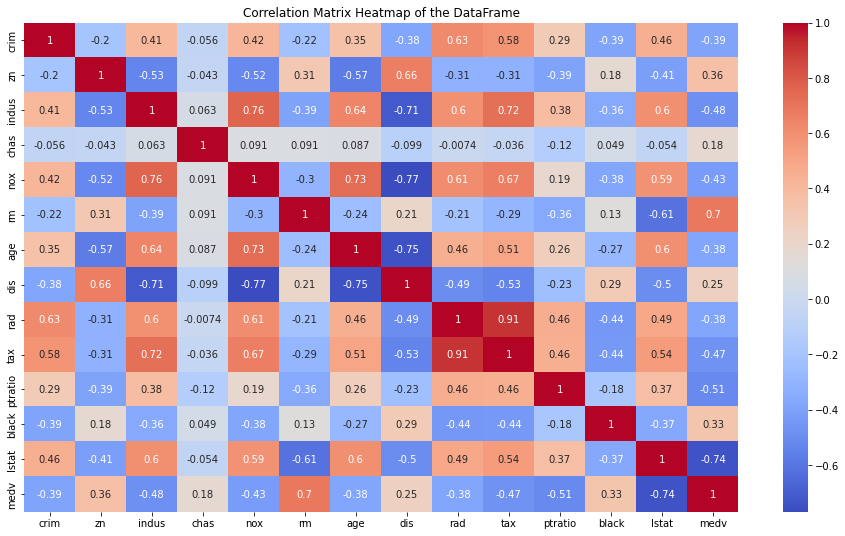

In [ ]:
correlation_matrix_heatmap(dataset)

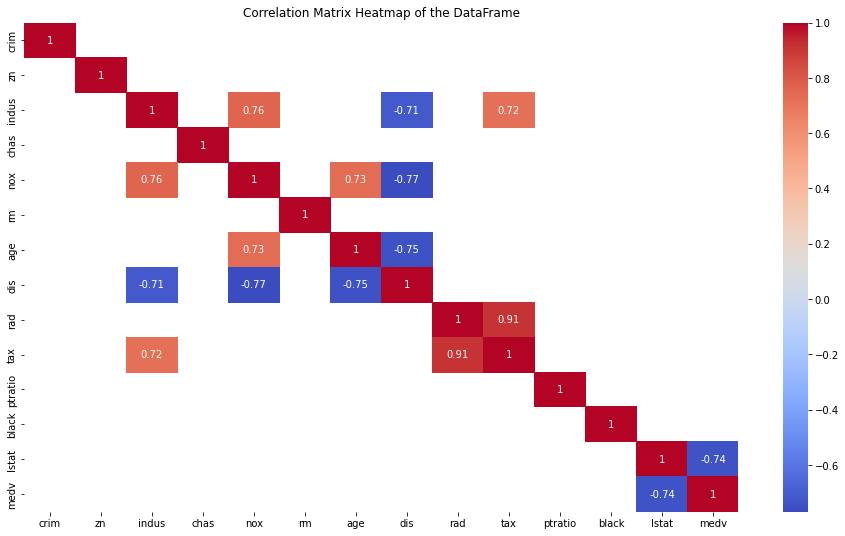

In [ ]:
correlation_matrix_heatmap_filter(dataset,0.7071)

In [ ]:
dataset.columns

['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'black',
 'lstat',
 'medv']

### We observe that these variables will be good:
#### rad -> tax, nox, indus
#### lstat -> medv, rm, age
#### black
#### chas
#### ptratio
#### zn

In [ ]:
dataset_reg_new_vars = vector_assembling(dataset,["lstat","tax","black","chas","ptratio","zn"],"Attributes","crim")

### We check its pvalue in order to know which are of statistical significance.

In [ ]:
r2_fourth_boston = regression('LR',[0.8,0.2],dataset_reg_new_vars,'Attributes','crim', True,["lstat","tax","black","chas","ptratio","zn"])

+--------------------+-------+--------------------+
|          Attributes|   crim|          prediction|
+--------------------+-------+--------------------+
|[2.97,255.0,394.2...|0.01381|  -1.543621809481503|
|[3.01,216.0,377.0...|0.06129|   -3.86830523243426|
|[3.11,244.0,386.3...|0.01538| -1.4062626020767777|
|[3.11,348.0,395.3...|0.02177|  0.6156813210524046|
|[3.32,403.0,388.4...|1.51902|-0.09193684572932881|
|[3.54,330.0,396.9...|0.36894|-0.44893766387229395|
|[3.57,276.0,393.5...|0.08187| -2.0605296279780516|
|[3.76,216.0,387.3...|0.03578| -3.1446095677303205|
|[4.61,370.0,387.9...|0.03049|   1.270575556831906|
|[4.69,398.0,389.7...|0.06911|  1.5709017658583058|
+--------------------+-------+--------------------+
only showing top 10 rows

lstat 0.000024005061215914836
tax 0.0000000000000002220446049250313
black 0.015975950172322895
chas 0.6311129641575883
ptratio 0.724488436810343
zn 0.29296078475127674
LR regression model

RMSE: 7.495
R2: 0.30


### We run the model now using the variables with statistical significance: lstat, rad, black and get the following results.

In [ ]:
dataset_reg_new_vars_stat = vector_assembling(dataset,["lstat","tax","black"],"Attributes","crim")

In [ ]:
r2_fifth_boston = regression('LR',[0.8,0.2],dataset_reg_new_vars_stat,'Attributes','crim', False)
r2_sixth_boston = regression('RF',[0.8,0.2],dataset_reg_new_vars_stat,'Attributes','crim', False)
r2_seventh_boston = regression('GBT',[0.8,0.2],dataset_reg_new_vars_stat,'Attributes','crim', False)

In [ ]:
bestmodel(4,r2_fourth_boston,r2_fifth_boston,r2_sixth_boston,r2_seventh_boston)

The best model is the iteration number 7 with a R^2 of: 0.7473


# Fat Dataset Curve Fitting


In [ ]:
path_csv_fat="/content/drive/Shareddrives/Infra DS Equipo 4/Classwork08/fat.csv"
dataset_fat = spark.read.csv(path_csv_fat,inferSchema=True, header =True)
dataset_fat.show(10)

+---+------+----+-------+---+------+------+------+-----+----+-----+-----+-----+-----+----+-----+------+-------+-----+
|_c0|brozek|siri|density|age|weight|height|adipos| free|neck|chest|abdom|  hip|thigh|knee|ankle|biceps|forearm|wrist|
+---+------+----+-------+---+------+------+------+-----+----+-----+-----+-----+-----+----+-----+------+-------+-----+
|  1|  12.6|12.3| 1.0708| 23|154.25| 67.75|  23.7|134.9|36.2| 93.1| 85.2| 94.5| 59.0|37.3| 21.9|  32.0|   27.4| 17.1|
|  2|   6.9| 6.1| 1.0853| 22|173.25| 72.25|  23.4|161.3|38.5| 93.6| 83.0| 98.7| 58.7|37.3| 23.4|  30.5|   28.9| 18.2|
|  3|  24.6|25.3| 1.0414| 22| 154.0| 66.25|  24.7|116.0|34.0| 95.8| 87.9| 99.2| 59.6|38.9| 24.0|  28.8|   25.2| 16.6|
|  4|  10.9|10.4| 1.0751| 26|184.75| 72.25|  24.9|164.7|37.4|101.8| 86.4|101.2| 60.1|37.3| 22.8|  32.4|   29.4| 18.2|
|  5|  27.8|28.7|  1.034| 24|184.25| 71.25|  25.6|133.1|34.4| 97.3|100.0|101.9| 63.2|42.2| 24.0|  32.2|   27.7| 17.7|
|  6|  20.6|20.9| 1.0502| 24|210.25| 74.75|  26.5|167.0|

In [ ]:
dataset_fat.dtypes

[('_c0', 'int'),
 ('brozek', 'double'),
 ('siri', 'double'),
 ('density', 'double'),
 ('age', 'int'),
 ('weight', 'double'),
 ('height', 'double'),
 ('adipos', 'double'),
 ('free', 'double'),
 ('neck', 'double'),
 ('chest', 'double'),
 ('abdom', 'double'),
 ('hip', 'double'),
 ('thigh', 'double'),
 ('knee', 'double'),
 ('ankle', 'double'),
 ('biceps', 'double'),
 ('forearm', 'double'),
 ('wrist', 'double')]

In [ ]:
dataset_fat.toPandas().isnull().sum()

_c0        0
brozek     0
siri       0
density    0
age        0
weight     0
height     0
adipos     0
free       0
neck       0
chest      0
abdom      0
hip        0
thigh      0
knee       0
ankle      0
biceps     0
forearm    0
wrist      0
dtype: int64

### We check for collinearity, we omit it because we do not want to increase R2 by artificial means

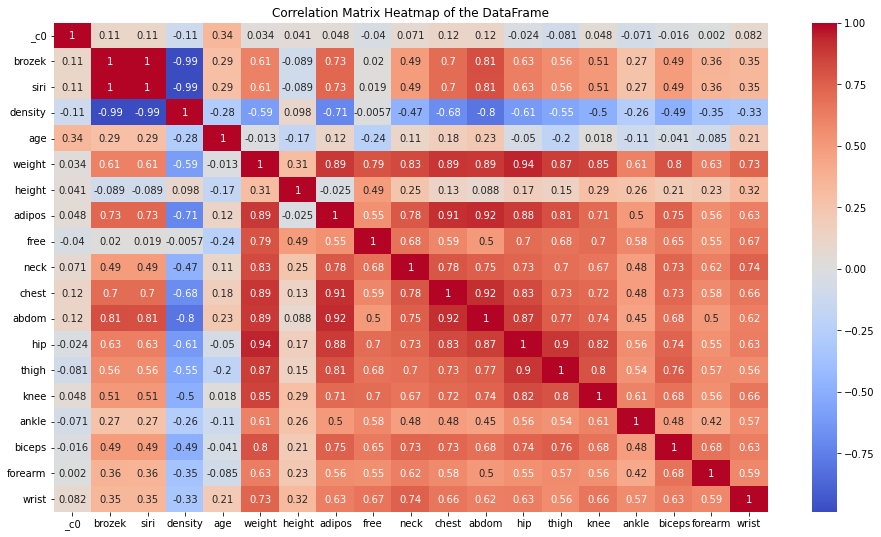

In [ ]:
correlation_matrix_heatmap(dataset_fat)

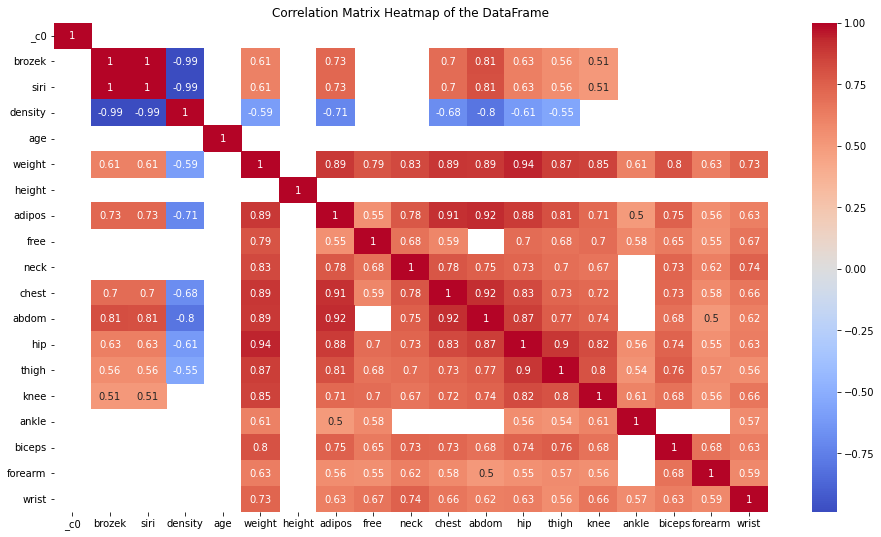

In [ ]:
correlation_matrix_heatmap_filter(dataset_fat,0.5)

In [ ]:
dataset_fat.columns

['_c0',
 'brozek',
 'siri',
 'density',
 'age',
 'weight',
 'height',
 'adipos',
 'free',
 'neck',
 'chest',
 'abdom',
 'hip',
 'thigh',
 'knee',
 'ankle',
 'biceps',
 'forearm',
 'wrist']

### We observe that these variables will be good:
#### density -> brozek, siri, adipos, chest, abdom, hip, thigh.
#### free -> knee, ankle, biceps, forearms, wrist.
#### height
#### age

In [ ]:
dataset_fat_reg = vector_assembling(dataset_fat,["density","free","height","age"],"Attributes","weight")

### We check its pvalue in order to know which are of statistical significance.

In [ ]:
r2_first_fat = regression('LR',[0.8,0.2],dataset_fat_reg,'Attributes','weight', True, ["density","free","height","age"])

+--------------------+------+------------------+
|          Attributes|weight|        prediction|
+--------------------+------+------------------+
|[1.018,149.3,69.5...|228.25|219.88250178602027|
|[1.025,113.5,65.5...| 166.0| 167.7884363265713|
|[1.0254,133.6,72....| 195.0| 192.4807556845858|
|[1.0263,170.4,73....|247.25| 239.5476899209683|
|[1.0279,151.1,70....| 217.0|213.79000907275065|
|[1.0298,136.1,70....|193.25| 192.5784066873133|
|[1.0328,133.9,66....|186.75|188.64296070799276|
|[1.0333,140.8,71....|195.75|194.61099829148827|
|[1.0334,143.6,68....| 199.5|200.10849527279925|
|[1.034,144.9,71.5...| 200.5|199.63905284914563|
+--------------------+------+------------------+
only showing top 10 rows

density 0
free 0
height 0.023206296125713566
age 0.10768339954331396
LR regression model

RMSE: 5.215
R2: 0.96


### We run the model now using the variable with statistical significance: density, free, height and get the following results.

In [ ]:
dataset_fat_reg_stat = vector_assembling(dataset_fat,["density","free","height"],"Attributes","weight")

In [ ]:
r2_second_fat = regression('LR',[0.8,0.2],dataset_fat_reg_stat,'Attributes','weight', False)
r2_third_fat = regression('RF',[0.8,0.2],dataset_fat_reg_stat,'Attributes','weight', False)
r2_fourth_fat = regression('GBT',[0.8,0.2],dataset_fat_reg_stat,'Attributes','weight', False)

+--------------------+------+------------------+
|          Attributes|weight|        prediction|
+--------------------+------+------------------+
|[1.0207,149.2,68.25]| 224.5|218.11072203231106|
|[1.0256,156.3,72.75]|227.75|222.05775961523273|
| [1.0308,152.7,70.5]| 215.5|213.08612547665246|
| [1.0372,161.2,69.5]|219.15|218.47433109085136|
|[1.0378,124.1,69.25]| 168.0|169.92377683944892|
|[1.0387,162.7,74.25]|219.25|218.20490107398052|
|[1.0398,117.2,66.75]| 157.0|159.62311551868936|
| [1.0403,133.3,67.0]| 178.0|179.97767370388055|
| [1.0414,139.6,71.5]|185.25|186.33257710471548|
|[1.0414,170.9,71.75]|226.75|226.82722212460465|
+--------------------+------+------------------+
only showing top 10 rows

LR regression model

RMSE: 3.260
R2: 0.99
+--------------------+------+------------------+
|          Attributes|weight|        prediction|
+--------------------+------+------------------+
| [1.0101,118.4,65.0]|191.75|189.54418605699854|
|[1.0202,240.5,72.25]|363.15|224.44598804392444|
|

In [ ]:
bestmodel(1,r2_first_fat,r2_second_fat,r2_third_fat,r2_fourth_fat)

The best model is the iteration number 2 with a R^2 of: 0.9866


In [ ]:
!jupyter nbconvert --to html /content/Classwork_08ipynb.ipynb

[NbConvertApp] Converting notebook /content/Classwork_08ipynb.ipynb to html
[NbConvertApp] Writing 826621 bytes to /content/Classwork_08ipynb.html
